# Hourly Time Series Forecasting using XGBoost

[If you haven't already first check out my previous notebook forecasting on the same data using Prophet](https://www.kaggle.com/robikscube/hourly-time-series-forecasting-with-prophet)

In this notebook we will walk through time series forecasting using XGBoost. The data we will be using is hourly energy consumption.

In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

plt.style.use('fivethirtyeight')

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

In [35]:
pjme = pd.read_csv('../data/3/PJME_hourly.csv', index_col=[0], parse_dates=[0])

# Make sure it’s a DatetimeIndex…
pjme.index = pd.to_datetime(pjme.index)

pjme = pjme.sort_index()       # or pjme.sort_index(inplace=True)

# Verify
print(f'The index is monotonically increasing: {pjme.index.is_monotonic_increasing}')

pjme.head()

The index is monotonically increasing: True


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


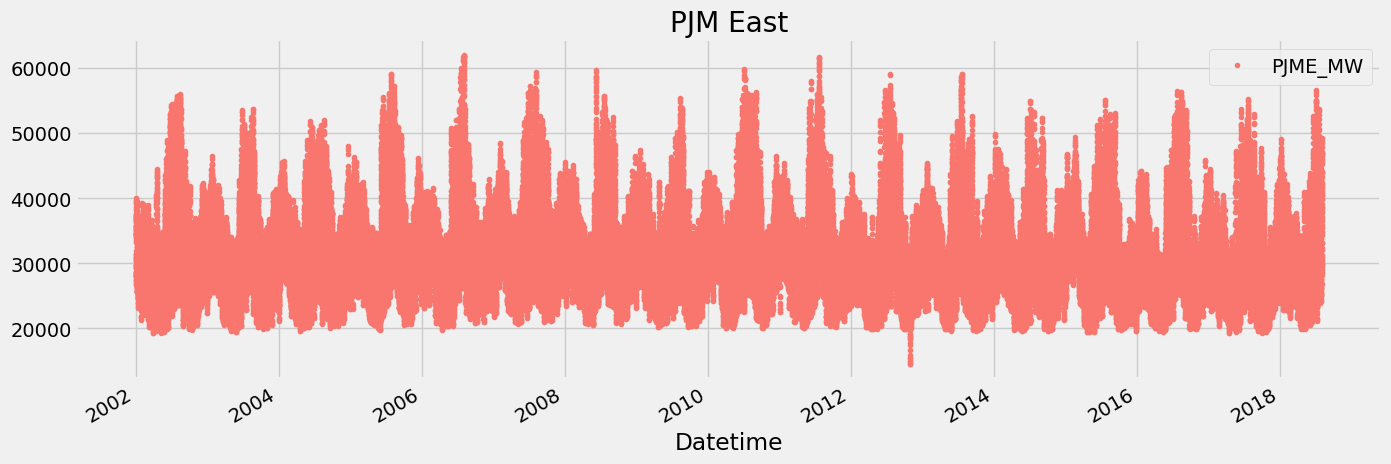

In [36]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [37]:
# assume `pjme` is your DataFrame with a DatetimeIndex and a single column 'PJME_MW'

# 1) First split off the final 20% as a true test set
train_val_df, test_df = train_test_split(
    pjme,
    test_size=0.2,
    shuffle=False              # keep the time order
)

# 2) Of the remaining 80%, split 25% of that (i.e. 0.25 * 0.8 = 0.20 of total) as your validation set
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.25,
    shuffle=False
)

# check sizes
print(f"Train: {len(train_df)} rows  ({len(train_df)/len(pjme):.0%})")
print(f" Val : {len(val_df)} rows  ({len(val_df)/len(pjme):.0%})")
print(f"Test : {len(test_df)} rows  ({len(test_df)/len(pjme):.0%})")


Train: 87219 rows  (60%)
 Val : 29073 rows  (20%)
Test : 29074 rows  (20%)


In [38]:
# Make sure the original is sorted
print("Original sorted?    ", pjme.index.is_monotonic_increasing)

# Boundary of the split
print("Train-val ends at: ", train_val_df.index[-1])
print("Test   starts at:  ", test_df.index[0])

# Confirm no overlap
assert train_val_df.index[-1] < test_df.index[0]

# And make sure each piece is still time-ordered
print("Train-val sorted?  ", train_val_df.index.is_monotonic_increasing)
print("Test   sorted?     ", test_df.index.is_monotonic_increasing)


Original sorted?     True
Train-val ends at:  2015-04-09 14:00:00
Test   starts at:   2015-04-09 15:00:00
Train-val sorted?   True
Test   sorted?      True


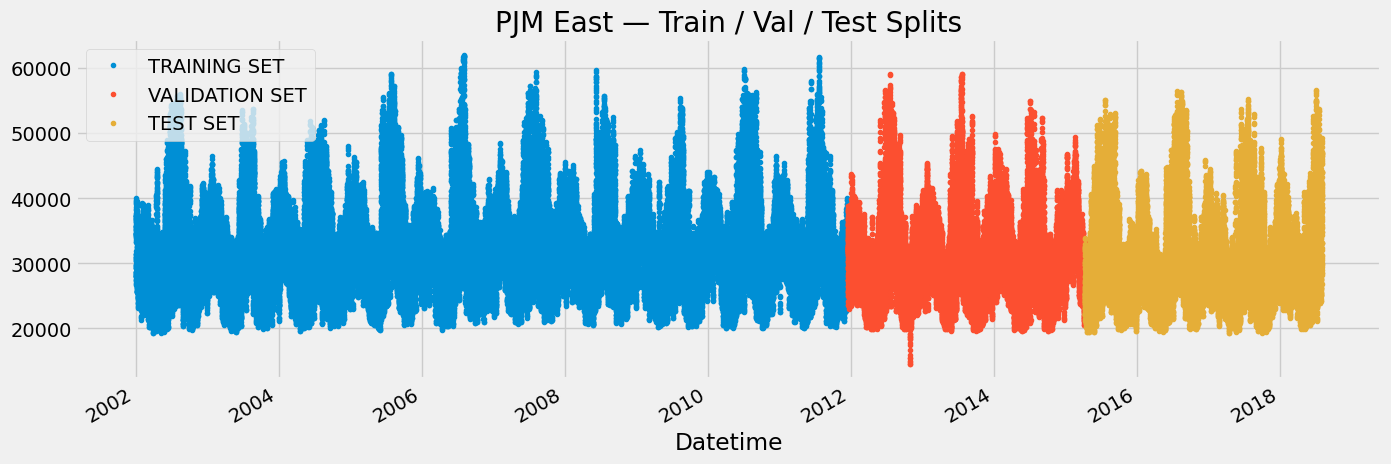

In [39]:
# 1) Rename each series so the legend is meaningful
train_s = train_df.rename(columns={'PJME_MW':'TRAINING SET'})
val_s   = val_df  .rename(columns={'PJME_MW':'VALIDATION SET'})
test_s  = test_df .rename(columns={'PJME_MW':'TEST SET'})

# 2) Combine them into one wide DataFrame
combined = pd.concat([train_s, val_s, test_s], axis=0)

# 3) Plot
_ = (
    combined
    .plot(
        figsize=(15,5),
        style='.',
        title='PJM East — Train / Val / Test Splits'
    )
)

# Create Time Series Features

In [40]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    # Make sure index is a DatetimeIndex
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Pull the index into a column
    df['date'] = df.index

    # Standard calendar features
    df['hour']       = df['date'].dt.hour
    df['dayofweek']  = df['date'].dt.dayofweek
    df['quarter']    = df['date'].dt.quarter
    df['month']      = df['date'].dt.month
    df['year']       = df['date'].dt.year
    df['dayofyear']  = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    # Week of year via the isocalendar (returns a DataFrame in newer pandas)
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)

    X = df[['hour','dayofweek','quarter','month','year',
            'dayofyear','dayofmonth','weekofyear']]

    if label:
        y = df[label]
        return X, y
    return X


In [41]:
X_train, y_train = create_features(train_df, label='PJME_MW')
X_val, y_val = create_features(val_df, label='PJME_MW')
X_test, y_test = create_features(test_df, label='PJME_MW')

In [42]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-01-01 01:00:00,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,5,1,1,1,2002,1,1,1


# Create XGBoost Model

In [45]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

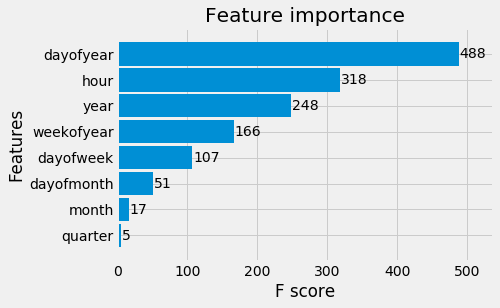

In [22]:
_ = plot_importance(reg, height=0.9)

In [20]:
import shap

# 1. Create a TreeExplainer for your fitted model
explainer = shap.TreeExplainer(reg)

# 2. Compute SHAP values on a background dataset (e.g. your validation set)
shap_values = explainer.shap_values(X_val)

# 3. Plot the familiar “beeswarm” summary plot
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns)

# — or if you just want a bar‐style importance ranking — 
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns, plot_type="bar")


NameError: name 'X_val' is not defined

# Forecast on Test Set

In [18]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

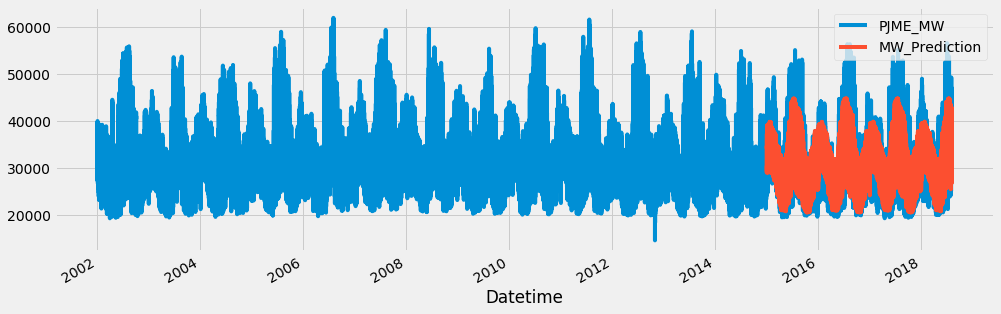

In [19]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

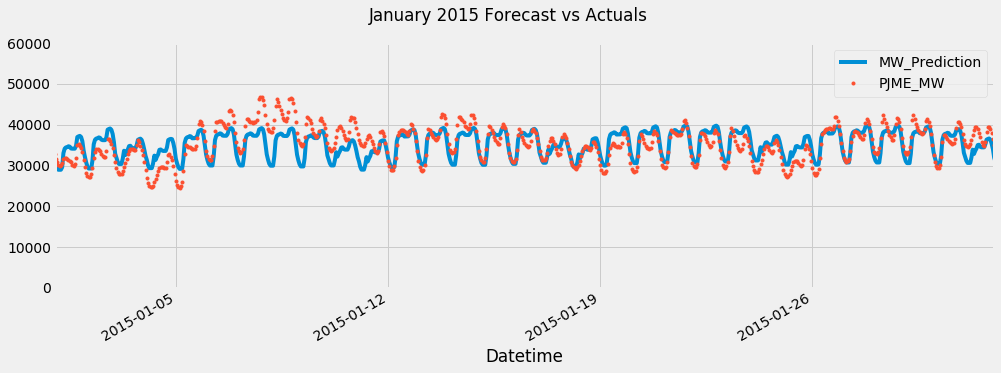

In [20]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

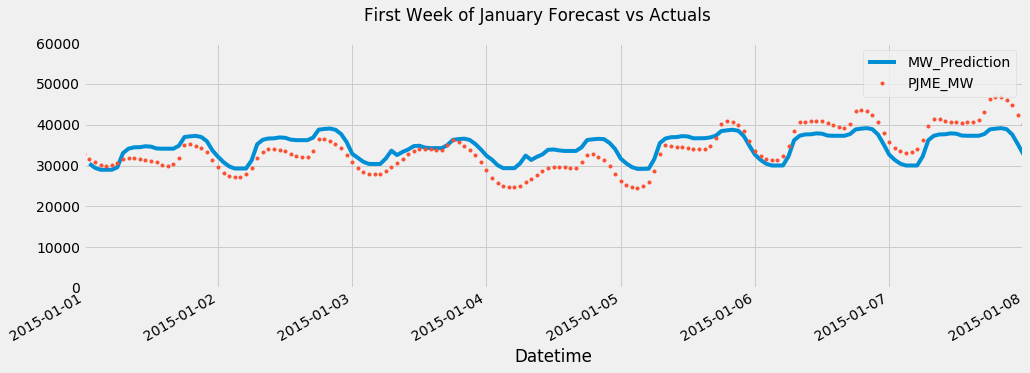

In [21]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

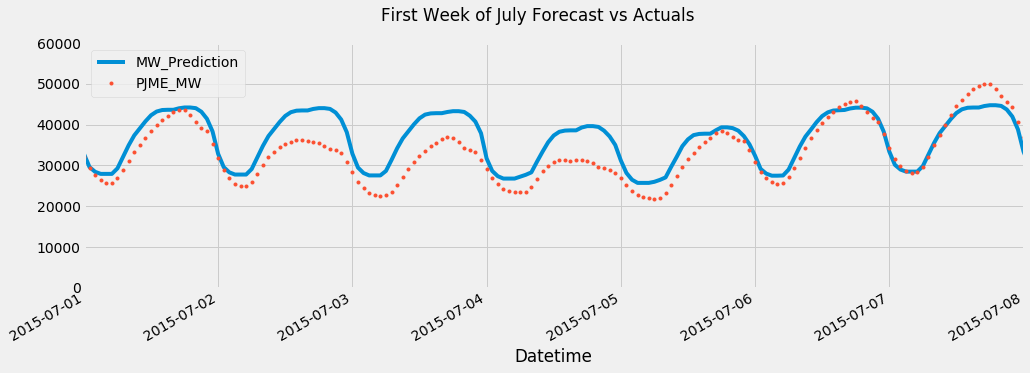

In [22]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics On Test Set
Our RMSE error is 13780445  
Our MAE error is 2848.89  
Our MAPE error is 8.9%

In [23]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

13780445.55710396

In [24]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2848.891429322955

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.94944673745318

# Look at Worst and Best Predicted Days

In [27]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [28]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW     ...         abs_error
year month dayofmonth                   ...                  
2016 7     4           28399.958333     ...       8587.006429
2017 2     24          26445.083333     ...       7369.422445
2015 12    25          24466.083333     ...       7118.841390
2017 2     20          27070.583333     ...       7030.197754
2015 7     3           30024.875000     ...       6996.156169
2017 6     28          30531.208333     ...       6995.380371
     2     8           28523.833333     ...       6987.864258
     9     2           24201.458333     ...       6978.933105
     2     25          24344.458333     ...       6939.820150
2018 2     21          27572.500000     ...       6904.919352

[10 rows x 4 columns]

Notice anything about the over forecasted days? 
- #1 worst day - July 4th, 2016 - is a holiday. 
- #3 worst day - December 25, 2015 - Christmas
- #5 worst day - July 4th, 2016 - is a holiday.   
Looks like our model may benefit from adding a holiday indicator.

In [29]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW      ...          abs_error
year month dayofmonth                    ...                   
2016 8     13          45185.833333      ...       13432.608887
           14          44427.333333      ...       13368.514404
     9     10          40996.166667      ...       11209.987793
           9           43836.958333      ...       11005.923828
2015 2     20          44694.041667      ...       10879.535889
2018 1     6           43565.750000      ...       10130.485921
2016 8     12          45724.708333      ...       10115.394287
2017 5     19          38032.583333      ...        9923.606689
     12    31          39016.000000      ...        9701.315430
2015 2     21          40918.666667      ...        9634.388184

[10 rows x 4 columns]

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may

In [30]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW     ...       abs_error
year month dayofmonth                   ...                
2016 10    3           27705.583333     ...      229.585205
2015 10    28          28500.958333     ...      388.023356
2016 10    8           25183.333333     ...      401.017090
     5     1           24503.625000     ...      428.289307
2017 10    29          24605.666667     ...      474.628988
2016 9     16          29258.500000     ...      491.070312
     3     20          27989.416667     ...      499.750488
     10    2           24659.083333     ...      516.188232
2017 10    14          24949.583333     ...      520.855794
2015 5     6           28948.666667     ...      546.640544

[10 rows x 4 columns]

# Plotting some best/worst predicted days

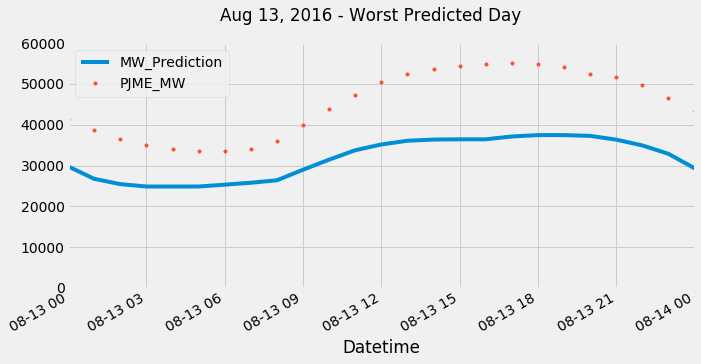

In [31]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

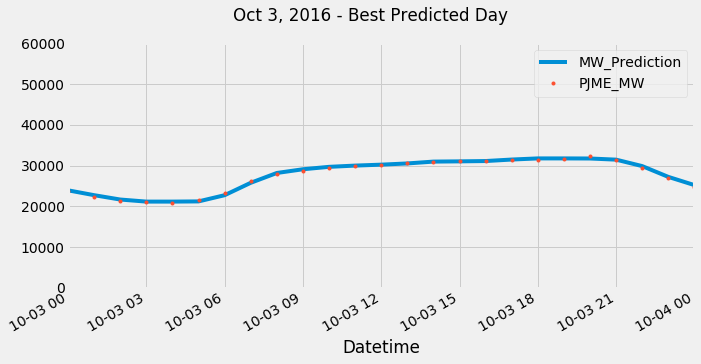

In [32]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

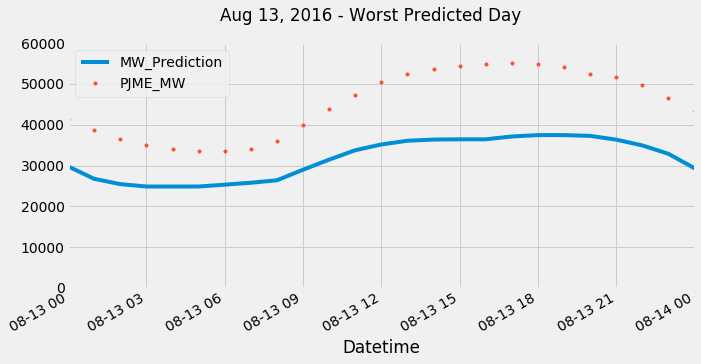

In [33]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

# Up next?
- Add Lag variables
- Add holiday indicators.
- Add weather data source.